## Import & Setup

Note, if you are getting errors like this:
```
...
from .extension import *
  File ".../isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'
```

Go into `isaacsim/extsUser/go4robo/go4robo_python/__init__.py` and comment out the following line:
```
from .extension import *
```

!! You need to uncomment this line if you plan to run the Isaac Sim extension !!

In [36]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [37]:
run_id = "20250502_204948"

## Get the generated designs from csv

In [38]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_Robot_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)
df

,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,s0_qx,s0_qy,s0_qz
0,0,Prior Design,1.0,9.801217,0,1,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000
1,1,Design 1,1.0,17.036291,1,1,0.789279,0.103226,0.447894,0.391864,-0.699438,0.027229,0.597066
2,2,Design 2,1.0,11.652141,1,1,0.514889,0.944595,0.586555,0.383276,-0.598630,0.126654,0.691882
3,3,Design 3,1.0,17.102970,1,1,0.807391,0.397677,0.165354,-0.330192,0.586914,0.619041,0.404096
4,4,Design 4,1.0,17.102970,1,1,0.725998,0.883306,0.623672,0.041615,0.500660,-0.603187,0.619494
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,1935,Design 1935,1.0,1.882079,49,1,0.999599,0.123056,0.953098,0.887304,0.137351,-0.000558,-0.440256
1936,1936,Design 1936,1.0,1.883110,49,1,0.998622,0.155585,0.951994,0.910038,0.156396,-0.020441,-0.383345
1937,1937,Design 1937,1.0,1.883431,49,1,0.997548,0.164152,0.955569,0.894312,0.168709,-0.000439,-0.414419
1938,1938,Design 1938,1.0,1.884977,49,1,0.997548,0.164152,0.955567,0.894289,0.168925,-0.000439,-0.414381


## Plot the tradespace

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [39]:
plot_tradespace(df)

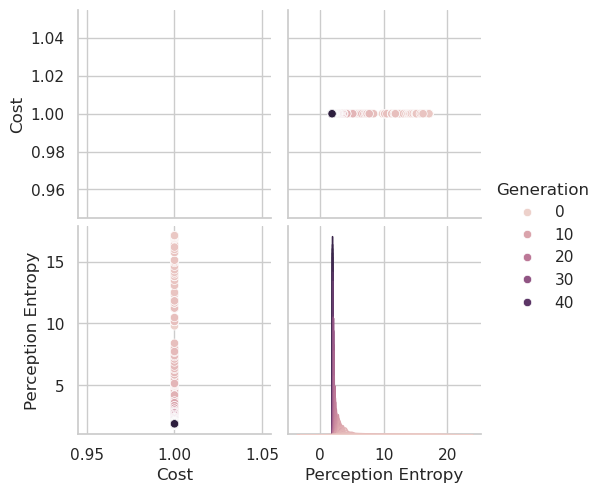

In [40]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)

pair_plot_df = df[["Generation", "Cost", "Perception Entropy"]]
sns.pairplot(pair_plot_df, hue="Generation", diag_kind="kde")


## Set up the problem from json

In [41]:
json_prolem_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/problem_Robot_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

prior_bot_from_problem = problem.prior_bot

## Plot any bot from the df above

In [ ]:
from plotly.subplots import make_subplots

INDEX_TO_PLOT = 1900

design_x_dict = df[df["id"] == INDEX_TO_PLOT].iloc[0].to_dict()
bot_x = problem.convert_1D_to_bot(design_x_dict)
design_x_fig = bot_x.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

design_0_dict = df[df["id"] == 0].iloc[0].to_dict()
bot_0 = problem.convert_1D_to_bot(design_0_dict)
design_0_fig = bot_0.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

combined_fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])
for trace in design_0_fig.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in design_x_fig.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(
    title_text=f"Design {INDEX_TO_PLOT} ({design_x_dict["Perception Entropy"]:.2f}) vs Design 0 (PE:{design_0_dict["Perception Entropy"]:.2f})",
    showlegend=False,
    width=1200,
    height=600,
)

combined_fig.show()